# YOLO를 이용한 뇌종양 객체 인식

## 0. 라이브러리

In [1]:
import os, shutil, random

import pandas as pd
import numpy as np

import cv2
import PIL
from PIL import Image, ImageDraw, ImageFont

from sklearn.model_selection import train_test_split
import albumentations as albu # augmentation

from ultralytics import YOLO

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

## 1. 데이터

* https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets
* 뇌종양 탐지를 위한 MRI 이미지에 포함된 bounding box 좌표이며, 데이터셋의 JPG 파일들은 원본 크기로 축 (Axial, Coronal, Sagittal) 에 따라서 나뉘어져 있습니다.
* 종양은 https://makesense.ai 를 사용하여 수작업으로 라벨링되었고, RSNA-MICCAI 경진대회 데이터에서 T1wCE 시리즈의 축 별로 0~400개의 이미지에 bounding box 좌표와 MGMT positive 라벨이 표시되어 있습니다.
* 여기서는 Axial 데이터를 사용하여 객체인식을 수행합니다.

### 1) 다운로드/로드

In [ ]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download('davidbroberts/brain-tumor-object-detection-datasets')

# print('Path to dataset files:', path)

100%|██████████| 12.3M/12.3M [00:01<00:00, 7.46MB/s]

Extracting files...


Path to dataset files: C:\Users\wjddl\.cache\kagglehub\datasets\davidbroberts\brain-tumor-object-detection-datasets\versions\5


#### 재구성

In [ ]:
DATASET_DIR = './dataset/brain_tumor'

TRAIN_DIR = DATASET_DIR+'/total/train'
TEST_DIR = DATASET_DIR+'/total/test'
VAL_DIR = DATASET_DIR+'/total/val'

In [ ]:
os.mkdir(DATASET_DIR+'/total')

# Train
os.mkdir(TRAIN_DIR)
os.mkdir(TRAIN_DIR+'/images')
os.mkdir(TRAIN_DIR+'/labels')

# Test
os.mkdir(TEST_DIR)
os.mkdir(TEST_DIR+'/images')
os.mkdir(TEST_DIR+'/labels')

# Validation
os.mkdir(VAL_DIR)
os.mkdir(VAL_DIR+'/images')
os.mkdir(VAL_DIR+'/labels')

In [ ]:
# 파일 복사
shutil.copytree(os.path.join(DATASET_DIR, 'images/train'), os.path.join(TRAIN_DIR, 'images'), dirs_exist_ok=True)
shutil.copytree(os.path.join(DATASET_DIR, 'labels/train'), os.path.join(TRAIN_DIR, 'labels'), dirs_exist_ok=True)
shutil.copytree(os.path.join(DATASET_DIR, 'images/test'), os.path.join(TEST_DIR, 'images'), dirs_exist_ok=True)
shutil.copytree(os.path.join(DATASET_DIR, 'labels/test'), os.path.join(TEST_DIR, 'labels'), dirs_exist_ok=True)

'./dataset/brain_tumor/total/test\\labels'

In [ ]:
# 파일 개수 비교
def count_files(folder):
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

def compare_folders(src_folder, dest_folder):
    src_count = count_files(src_folder)
    dest_count = count_files(dest_folder)

    if src_count==dest_count:
        print(f'{src_folder} → {dest_folder}: 파일 개수 동일 ({src_count}개)')
    else:
        print(f'{src_folder} → {dest_folder}: 파일 개수 불일치! (원본: {src_count}개, 복사본: {dest_count}개)')

compare_folders(os.path.join(DATASET_DIR, 'images/train'), os.path.join(TRAIN_DIR, 'images'))
compare_folders(os.path.join(DATASET_DIR, 'labels/train'), os.path.join(TRAIN_DIR, 'labels'))
compare_folders(os.path.join(DATASET_DIR, 'images/test'), os.path.join(TEST_DIR, 'images'))
compare_folders(os.path.join(DATASET_DIR, 'labels/test'), os.path.join(TEST_DIR, 'labels'))

./dataset/brain_tumor\images/train → ./dataset/brain_tumor/total/train\images: 파일 개수 동일 (310개)
./dataset/brain_tumor\labels/train → ./dataset/brain_tumor/total/train\labels: 파일 개수 동일 (296개)
./dataset/brain_tumor\images/test → ./dataset/brain_tumor/total/test\images: 파일 개수 동일 (75개)
./dataset/brain_tumor\labels/test → ./dataset/brain_tumor/total/test\labels: 파일 개수 동일 (75개)


In [ ]:
# 라벨 없는 이미지 삭제
def remove_images_without_labels(folder_dir):
    images_folder = os.path.join(folder_dir, 'images')
    labels_folder = os.path.join(folder_dir, 'labels')

    images = os.listdir(images_folder)
    labels = os.listdir(labels_folder)

    images_without_labels = set(images)-set([os.path.splitext(label)[0] + '.jpg' for label in labels])

    for image in images_without_labels:
        image_path = os.path.join(images_folder, image)
        os.remove(image_path)

    print(f'{len(images_without_labels)} 개의 라벨이 없는 이미지가 제거되었습니다.')

In [ ]:
remove_images_without_labels(TRAIN_DIR)

14 개의 라벨이 없는 이미지가 제거되었습니다.


#### 검증 데이터셋 만들기

* 학습 데이터셋에서 20% 분리

In [ ]:
def create_validation_set(train_dir, val_dir, split_ratio=0.2):

    labels_dir = os.path.join(train_dir, 'labels')
    images_dir = os.path.join(train_dir, 'images')

    label_files = os.listdir(labels_dir)
    num_files_to_move = int(len(label_files)*split_ratio)
    files_to_move = random.sample(label_files, num_files_to_move)

    for file_name in files_to_move:
        src = os.path.join(labels_dir, file_name)
        dst = os.path.join(val_dir, 'labels', file_name)
        shutil.move(src, dst)

    for file_name in files_to_move:
        img_name = os.path.splitext(file_name)[0] + '.jpg'
        src = os.path.join(images_dir, img_name)
        dst = os.path.join(val_dir, 'images', img_name)
        shutil.move(src, dst)

In [5]:
create_validation_set(TRAIN_DIR, VAL_DIR)

### 2) 탐색

In [6]:
# 개수 확인
def count_files(folder_dir):

    images_folder = os.path.join(folder_dir, 'images')
    labels_folder = os.path.join(folder_dir, 'labels')

    num_images = len(os.listdir(images_folder))
    num_labels = len(os.listdir(labels_folder))

    return num_images, num_labels

In [7]:
train_images, train_labels = count_files(TRAIN_DIR)
val_images, val_labels = count_files(VAL_DIR)
test_images, test_labels = count_files(TEST_DIR)

print(f'train 파일 개수: {train_images} 이미지, {train_labels} 라벨')
print(f'val 파일 개수: {val_images} 이미지, {val_labels} 라벨')
print(f'test 파일 개수: {test_images} 이미지, {test_labels} 라벨')

train 파일 개수: 237 이미지, 237 라벨
val 파일 개수: 59 이미지, 59 라벨
test 파일 개수: 75 이미지, 75 라벨


In [9]:
# 데이터 샘플 확인
def show_random_images_from_train(train_dir, num_rows, num_cols):

    images_folder = os.path.join(train_dir, 'images')
    labels_folder = os.path.join(train_dir, 'labels')

    image_files = os.listdir(images_folder)

    random_images = random.sample(image_files, num_rows*num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axes = axes.flatten()

    for i, image_file in enumerate(random_images):

        image_path = os.path.join(images_folder, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)

        image = mpimg.imread(image_path)

        with open(label_path, 'r') as f:
            label = f.read().strip()

        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}', fontsize=15)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


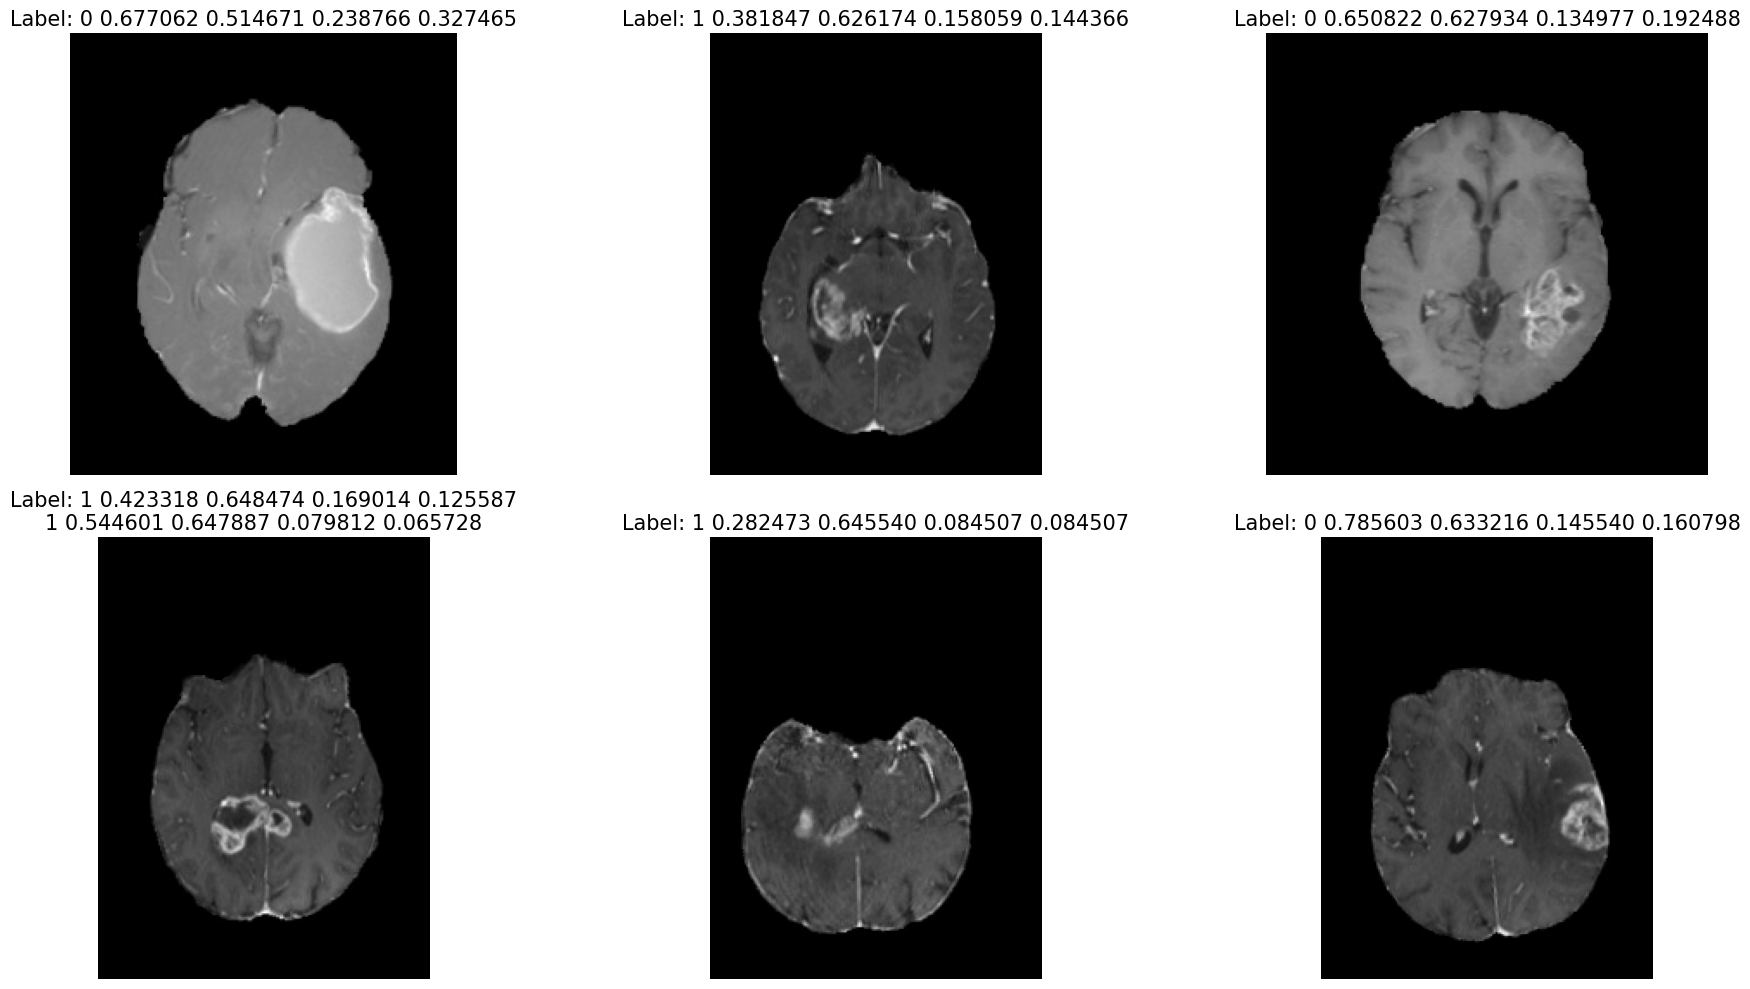

In [12]:
num_rows = 2
num_cols = 3

show_random_images_from_train(TRAIN_DIR, num_rows, num_cols)

## 2. 모델링

### YOLO
0. 설치: pip install ultralytics
1. 데이터셋 준비: YOLO 포맷 (images/, labels/, dataset.yaml)
2. 데이터셋 설정: dataset.yaml 생성 (path, nc, names 설정)
3. YOLO 모델 학습: model.train()
4. 모델 성능 평가: model.val()
5. 객체 탐지 테스트: model()
6. 학습된 모델 저장 및 배포: model.export()


### 1) 모델 로드

In [28]:
model = YOLO('yolov8s.pt') # s: small -> weight의 개수가 적다

100%|██████████| 21.5M/21.5M [00:02<00:00, 9.79MB/s]


### 2) dataset.yaml 파일 작성

* 데이터 경로 및 클래스 정보 정의

In [ ]:
# 데이터셋 디렉토리 구조
# total/
# │── test/
# │   ├── images/
# │   ├── labels/
# │── train/
# │   ├── images/
# │   ├── labels/
# │── val/
# │   ├── images/
# │   ├── labels/
# │── dataset.yaml

In [ ]:
text = '''
# dataset path
path:                   # dataset.yaml이 있는 폴더 경로
train: train/images
val: val/images
test: test/images

# number of classes
nc: 2

# class names
names: ['negative', 'positive']
'''

In [59]:
with open(DATASET_DIR+'/total/dataset.yaml', 'w') as file:
    file.write(text)

### 3) 모델 학습

In [ ]:
MODEL_SAVE_DIR = './models'

# 모델 학습 -> 16m 23s
model.train(data=DATASET_DIR+'/total/dataset.yaml', epochs=200, project=MODEL_SAVE_DIR, name='YOLO_brain-tumor')

New https://pypi.org/project/ultralytics/8.3.80 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.78  Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=./dataset/brain_tumor/total/dataset.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=./models, name=YOLO_brain-tumor, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

100%|██████████| 755k/755k [00:00<00:00, 11.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 11.5MB/s]


AMP: checks passed 


train: Scanning F:\회사\취업준비\포트폴리오\portfolio\의료바이오AI\AI헬스케어데이터정제및가공\dataset\brain_tumor\total\train\labels... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:01<00:00, 205.36it/s]


train: New cache created: F:\\\\portfolio\AI\AI\dataset\brain_tumor\total\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning F:\회사\취업준비\포트폴리오\portfolio\의료바이오AI\AI헬스케어데이터정제및가공\dataset\brain_tumor\total\val\labels... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 403.98it/s]


val: New cache created: F:\\\\portfolio\AI\AI\dataset\brain_tumor\total\val\labels.cache
Plotting labels to models\YOLO_brain-tumor\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to models\YOLO_brain-tumor
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.71G      1.837      5.319      1.574         27        640: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         59         60      0.126      0.375       0.12     0.0433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.62G       1.33      2.518      1.186         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         59         60      0.277      0.451      0.325       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.52G      1.222      2.028      1.163         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         59         60      0.328      0.312      0.271      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.77G      1.192      1.904      1.141         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         59         60      0.471      0.222      0.311       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.77G      1.171      1.669      1.152         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

                   all         59         60      0.288      0.333      0.159      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.77G      1.244      1.538      1.114         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

                   all         59         60      0.299      0.188      0.191     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200       3.5G      1.186       1.52      1.112         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


                   all         59         60       0.14      0.104     0.0474     0.0264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.51G      1.233      1.553      1.146         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         59         60      0.292      0.208      0.219      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.62G      1.211      1.306      1.095         31        640: 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         59         60      0.506      0.458      0.411      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200       3.5G      1.147      1.369      1.123         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         59         60      0.632      0.235      0.193     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.49G      1.108      1.247      1.084         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

                   all         59         60      0.593      0.125     0.0625     0.0209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.51G      1.122      1.139      1.088         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         59         60      0.709      0.111      0.103      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.77G      1.117      1.128      1.103         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         59         60      0.588      0.431       0.49      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200       3.5G      1.145      1.193        1.1         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

                   all         59         60      0.591      0.705      0.631       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       3.5G      1.075      1.086      1.077         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         59         60      0.609      0.771      0.753      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.51G      1.078      1.071       1.07         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         59         60      0.578      0.611      0.642      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.48G      1.122      1.089       1.09         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

                   all         59         60      0.409      0.528      0.452      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200       3.5G      1.065      1.059      1.064         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         59         60      0.623      0.462      0.421      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200       3.5G      1.055      1.007      1.057         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         59         60      0.658      0.766      0.778      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.51G     0.9828      1.001      1.009         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

                   all         59         60      0.386      0.597      0.507      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.77G      1.034     0.9664      1.045         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         59         60      0.489       0.59      0.513       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.49G      1.066      1.087      1.082         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         59         60      0.606      0.688      0.687      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.49G      1.017     0.9876       1.05         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         59         60      0.526      0.736      0.714       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.51G      0.983     0.9217      1.023         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

                   all         59         60      0.402      0.622      0.492      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.77G       1.07     0.9651      1.071         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         59         60      0.701      0.542      0.437      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       3.5G      1.011     0.9094      1.051         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all         59         60       0.77       0.53      0.536      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200       3.5G     0.9724     0.9396      1.022         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         59         60      0.527      0.616      0.597        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.51G     0.9794     0.8727       1.03         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

                   all         59         60      0.849      0.764      0.892      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.77G     0.9665      0.816      1.009         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         59         60      0.769      0.794      0.823      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200       3.5G      0.967     0.8687      1.018         16        640: 100%|██████████| 15/15 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         59         60      0.794       0.79      0.873       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.49G     0.9479     0.8082      1.037         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         59         60      0.704      0.749      0.818      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.51G     0.9512     0.8019      1.021         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         59         60      0.709      0.715      0.799       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.62G     0.9859     0.8271      1.045         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         59         60      0.739      0.783       0.88      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200       3.5G     0.9609     0.8272      1.022         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         59         60       0.57      0.827      0.794      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       3.5G     0.9299     0.7997      1.001         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         59         60      0.581      0.668      0.688      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.51G     0.8623     0.7273     0.9845         12        640: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         59         60      0.686      0.708      0.782      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.77G     0.9544     0.7594       1.04         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         59         60      0.834      0.883      0.924      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       3.5G      0.896     0.8124      0.997         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         59         60      0.631      0.583      0.591      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200       3.5G     0.9411     0.8964      1.031         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         59         60      0.739      0.521      0.657      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.51G     0.9232     0.7023     0.9911         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         59         60      0.653      0.824      0.828       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.62G     0.9583     0.7293      1.014         15        640: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         59         60      0.807      0.868      0.913      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.49G     0.8899     0.6956     0.9906         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         59         60      0.687       0.57      0.788      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.49G      0.885     0.7554      0.987         29        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         60      0.729      0.742      0.788      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.51G     0.9117     0.7818     0.9967         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         59         60      0.812      0.812      0.872       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.77G     0.8854     0.7429     0.9727         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

                   all         59         60      0.809      0.787      0.843      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200       3.5G     0.8947     0.7108     0.9999         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         59         60      0.648      0.798      0.803      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200       3.5G      0.863     0.6852     0.9895         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         59         60      0.742      0.937       0.93      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.51G     0.9288     0.7088     0.9864         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         59         60      0.757      0.886      0.881      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.48G     0.8797     0.7209      0.976         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         59         60       0.74      0.889      0.881      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       3.5G     0.8858     0.7083     0.9908         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         59         60      0.619      0.785      0.762      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.49G     0.8381     0.6456     0.9675         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         59         60      0.815      0.781      0.843      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.51G     0.8758     0.6895     0.9799         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         60      0.787      0.828      0.882       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.62G     0.8079     0.5913     0.9617         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         59         60      0.837      0.875      0.878      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       3.5G     0.8498     0.6176     0.9559         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         59         60      0.871      0.833      0.914       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.49G     0.8354     0.6455     0.9729         30        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         59         60      0.877      0.819      0.903      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.51G     0.8318     0.6791     0.9786         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         59         60      0.762      0.889      0.891       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.77G     0.8737     0.6917     0.9873         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         59         60      0.756      0.854      0.868      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200       3.5G     0.8489     0.6202     0.9677         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         59         60      0.806       0.77       0.83      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       3.5G     0.8157     0.6142     0.9648         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         59         60      0.809      0.771      0.851      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.51G     0.8359     0.6098     0.9715         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         59         60       0.74      0.729      0.759      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.77G     0.8024     0.5867     0.9491         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         59         60      0.708      0.802      0.831      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       3.5G      0.851     0.6203     0.9877         16        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         59         60      0.872      0.806      0.921      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200       3.5G     0.8489     0.6272          1         35        640: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         59         60      0.894      0.792      0.901      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200       3.5G      0.845     0.5886     0.9715         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         59         60       0.84      0.774      0.835      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.62G      0.836     0.5665     0.9866         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         59         60      0.932      0.824      0.909      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       3.5G     0.8063     0.6068     0.9637         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         59         60      0.899      0.809      0.901       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.49G     0.8332     0.5937     0.9612         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         59         60      0.777      0.821      0.844      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.51G     0.8026     0.5647     0.9611         15        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         59         60      0.819      0.764      0.865      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.63G     0.7848      0.561     0.9541         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         59         60      0.833      0.689      0.847      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200       3.5G     0.7864     0.5519     0.9486         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         59         60      0.796      0.765      0.803       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       3.5G     0.8068     0.5842     0.9513         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

                   all         59         60      0.839      0.778      0.883        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.51G     0.7345       0.52     0.9425         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         59         60      0.919      0.837      0.942      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.77G     0.7828     0.5591     0.9386         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         59         60      0.846      0.881      0.934      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200       3.5G     0.7117     0.5261     0.9318         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         59         60      0.861      0.896      0.923      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.49G     0.7616     0.5615     0.9448         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         59         60      0.864      0.868       0.94      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.51G     0.7621     0.5391      0.931         32        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         60      0.851      0.882      0.924       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.62G       0.75     0.5266     0.9286         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         60      0.897      0.864      0.917      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200       3.5G     0.7184     0.5204     0.9281         14        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         59         60      0.919      0.879      0.952      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       3.5G     0.7316     0.5221     0.9251         15        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         59         60      0.912      0.689       0.87      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.51G     0.7913     0.5751     0.9647         16        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

                   all         59         60      0.913      0.812      0.898      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.77G     0.7758     0.5264     0.9607         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         59         60      0.805      0.908      0.911      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200       3.5G     0.7203     0.4884      0.933         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         59         60      0.795      0.904      0.897      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.49G     0.7994     0.5316     0.9436         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         59         60      0.846      0.898      0.921      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.51G     0.7465     0.5203     0.9474         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         59         60      0.863      0.903       0.94      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.77G     0.7124     0.4816     0.9186         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         59         60      0.905      0.935       0.96      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       3.5G     0.7068      0.507     0.9477         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         59         60      0.894      0.905      0.947      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       3.5G     0.7199     0.4681     0.9199         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         59         60      0.913       0.93      0.951      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.51G     0.7282     0.4975      0.931         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         59         60      0.865      0.907      0.937      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.62G     0.7312     0.4553     0.9145         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         59         60      0.826      0.826      0.891      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200       3.5G      0.686     0.4844     0.9173         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         59         60      0.938      0.871       0.93      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.49G     0.7362     0.4861     0.9359         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         59         60      0.945      0.925      0.944      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.51G     0.6911     0.4641     0.9276         33        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         59         60      0.945       0.93      0.944      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.62G     0.6698      0.449      0.905         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         59         60      0.948      0.868      0.927      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       3.5G     0.6745     0.4464      0.934         16        640: 100%|██████████| 15/15 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         60      0.927      0.921      0.923      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       3.5G     0.6639      0.452     0.9034         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         59         60       0.96      0.902      0.946      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.51G     0.7033     0.4463     0.9142         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         59         60      0.918      0.811      0.919       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      3.62G      0.698     0.4604     0.9198         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         59         60       0.91      0.798      0.911      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200       3.5G     0.6877     0.4592     0.9297         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         59         60      0.876      0.778      0.894      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200       3.5G     0.6572     0.4806     0.9247         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         59         60      0.914      0.835       0.93      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.51G     0.6603     0.4258     0.9089         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

                   all         59         60      0.816      0.859      0.893      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      3.62G     0.6414     0.4328     0.8994         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         59         60      0.843      0.899      0.902      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       3.5G     0.6239     0.4397     0.8882         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         59         60      0.888       0.91      0.934      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       3.5G     0.6483     0.4471     0.9102         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         59         60       0.86      0.898       0.92      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.51G     0.6667     0.4675     0.9093         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         59         60      0.856       0.89      0.917      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.77G     0.6608     0.4399     0.9167         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         59         60      0.939       0.89      0.939      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200       3.5G     0.6367     0.4328     0.8944         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         59         60      0.963      0.875      0.936      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.49G     0.7131     0.4893     0.9425         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         59         60      0.962      0.846      0.961      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.51G     0.6477     0.4276     0.9023         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         59         60      0.915      0.882      0.945      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.77G     0.6262     0.3999     0.8993         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         59         60      0.898      0.844      0.957      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200       3.5G     0.6374      0.408     0.9087         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         59         60      0.951      0.826      0.959      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.49G     0.6798     0.4562     0.9393         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         60      0.868      0.944      0.962       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.52G     0.6101     0.4104     0.8867         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         59         60      0.885      0.933      0.951      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.77G     0.6268     0.4247      0.906         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         60      0.933      0.863      0.929      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200       3.5G     0.6363     0.4281     0.9291         12        640: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         59         60      0.942      0.844      0.937      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.49G     0.5995     0.3927     0.8933         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         59         60      0.973       0.91       0.98      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.51G      0.603      0.409     0.8863         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         59         60      0.838      0.903      0.937      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.77G     0.6183     0.4462     0.8939         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         59         60      0.893      0.834      0.901      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200       3.5G     0.5947     0.3942      0.879         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         59         60      0.933      0.845      0.925      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.49G     0.6216     0.4447     0.9211         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         59         60      0.949      0.858      0.944      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.51G     0.5809     0.4074     0.8835         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         59         60       0.94      0.843      0.916        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.77G     0.6156     0.4117     0.9074         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         60      0.866      0.882      0.908      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200       3.5G     0.6053     0.3842     0.9088         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         59         60      0.869      0.887      0.922      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       3.5G     0.6227     0.3949     0.9185         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         59         60      0.921      0.889      0.936      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.51G       0.64     0.4125     0.9094         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         59         60      0.929      0.903      0.933      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.63G      0.577     0.3891     0.8777         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         60      0.922      0.869      0.923      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200       3.5G     0.5651      0.382     0.8834         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         59         60      0.848      0.924      0.907      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.49G     0.5802     0.3739     0.9007         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         60      0.893      0.924      0.943      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.51G     0.5881     0.3872      0.885         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

                   all         59         60      0.881      0.958      0.951      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.62G     0.5707     0.3717     0.8756         12        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         59         60       0.89      0.907      0.939      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.49G     0.5489     0.3595     0.8638         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         59         60      0.883      0.871      0.909      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.49G     0.5944     0.4002     0.9148         30        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         59         60      0.973      0.873      0.936      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200       3.5G     0.5806     0.3807        0.9         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         59         60      0.919      0.951      0.969      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.62G     0.5651     0.3818     0.8937         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         59         60       0.88      0.926      0.949      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200       3.5G     0.5232     0.3427      0.881         31        640: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         60      0.859      0.918      0.924      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200       3.5G      0.561     0.3651     0.8742         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         59         60      0.911      0.882       0.92      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.51G     0.5486      0.365     0.8951         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

                   all         59         60      0.893      0.838      0.927      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.62G     0.5549     0.3952     0.8797         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         59         60      0.909      0.874      0.937      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200       3.5G     0.5421      0.374      0.876         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         59         60      0.922      0.908       0.95      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200       3.5G     0.5316     0.3504     0.8938         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         59         60      0.956      0.868      0.941      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      3.51G     0.5309     0.3899     0.8934         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         59         60      0.934      0.871      0.949      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.62G      0.509     0.3371      0.864         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         59         60       0.91      0.884      0.937      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200       3.5G     0.4976     0.3336     0.8674         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         59         60      0.948      0.912      0.968      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200       3.5G     0.5412     0.3473      0.898         32        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         59         60      0.952      0.923      0.974       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.51G     0.5342      0.351      0.877         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         59         60      0.967      0.873      0.951      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.77G     0.5523     0.3679     0.8973         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

                   all         59         60      0.966      0.905      0.948      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200       3.5G     0.5241     0.3593     0.8819         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         59         60      0.911      0.955      0.959      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.49G      0.535     0.3451     0.8801         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         59         60      0.929      0.903       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.51G     0.5188     0.3326     0.8596         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         59         60      0.893      0.915      0.929      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      3.62G     0.5095     0.3382     0.8727         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         59         60      0.928      0.882      0.938      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200       3.5G     0.4773     0.3236     0.8533         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         59         60      0.935      0.908       0.96      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200       3.5G       0.52     0.3491     0.8748         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         59         60      0.867      0.948      0.949        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      3.51G     0.4775      0.324     0.8654         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         60        0.9      0.875      0.945      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.77G     0.4804     0.3221     0.8729         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         59         60      0.859      0.924      0.924      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200       3.5G     0.4838     0.3558     0.8555         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         59         60      0.848      0.918      0.912      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      3.49G     0.4995     0.3324     0.8781         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         59         60      0.906      0.864      0.931      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      3.51G     0.4988     0.3362     0.8635         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         59         60      0.828      0.951      0.937        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.62G     0.4798     0.3167     0.8524         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         59         60      0.835      0.943       0.94      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200       3.5G     0.4551     0.3081     0.8641         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         59         60      0.897      0.944      0.954      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200       3.5G     0.4792       0.32     0.8582         30        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

                   all         59         60      0.843      0.973      0.953      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200       3.5G     0.5157     0.3291     0.8764         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         59         60      0.903       0.91      0.951      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      3.62G     0.4726     0.3267     0.8581         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         59         60      0.944      0.875      0.952      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      3.49G       0.47     0.3168     0.8797         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         59         60      0.952      0.848      0.952       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.49G     0.5025     0.3296     0.8643         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         59         60      0.971      0.844      0.954      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      3.51G     0.4548     0.3095     0.8522         13        640: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         59         60      0.879      0.959      0.958      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      3.77G     0.4541     0.3056     0.8696         29        640: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         60      0.919      0.971      0.961      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200       3.5G     0.4663     0.3164      0.865         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         60      0.974      0.896      0.949      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200       3.5G     0.4177     0.2918     0.8359         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         59         60      0.853      0.979      0.954       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.51G     0.4468     0.3096     0.8435         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         59         60      0.883      0.921      0.952      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.77G     0.4502     0.3064     0.8652         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         59         60      0.901      0.884      0.942      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200       3.5G      0.455     0.3221     0.8595         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         59         60      0.889       0.91      0.935      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.49G     0.4459     0.2976     0.8679         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         59         60       0.89      0.927      0.935      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.51G     0.4458     0.3089     0.8552         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

                   all         59         60      0.908      0.931      0.947      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      3.62G     0.4321     0.3146     0.8614         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         60      0.914      0.941      0.953      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200       3.5G     0.4408     0.3022     0.8369         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         59         60      0.905      0.956      0.943      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200       3.5G     0.4538       0.29     0.8537         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         59         60      0.887      0.931      0.934      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.51G     0.3895     0.2678     0.8206         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

                   all         59         60       0.96      0.869      0.939      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.62G     0.4432     0.3158     0.8616         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

                   all         59         60      0.969      0.899      0.941      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200       3.5G     0.4401     0.3116     0.8672         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         59         60       0.92      0.919      0.953      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200       3.5G     0.4178     0.2713     0.8417         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         59         60       0.88      0.944      0.952      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      3.51G     0.4173     0.3025     0.8561         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         59         60      0.923      0.953      0.954      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.77G     0.4182      0.286     0.8429         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         59         60      0.904      0.935       0.95      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       3.5G     0.4153     0.2861      0.845         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

                   all         59         60      0.912      0.933      0.956      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      3.49G     0.4141     0.2873     0.8442         29        640: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         59         60       0.95      0.868      0.953       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.51G     0.4754     0.3323     0.8685         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         59         60      0.964      0.844      0.938      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      3.77G     0.4017     0.2874     0.8404         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         59         60      0.889      0.919      0.941      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200       3.5G     0.4152     0.2845     0.8489         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         59         60      0.922      0.861      0.939      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      3.49G     0.4287     0.2897     0.8603         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         59         60      0.859      0.916       0.94       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.51G     0.4149      0.281     0.8525         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

                   all         59         60      0.859      0.908      0.942      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      3.77G     0.3879     0.2733      0.835         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         59         60      0.859      0.908      0.942      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200       3.5G     0.4333     0.2889     0.8656         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         60      0.933       0.85      0.934      0.715


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.49G     0.3547     0.2451     0.8005         13        640: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         59         60      0.846      0.906       0.93        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.51G     0.3432     0.2231     0.8021         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

                   all         59         60      0.847      0.917      0.929      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.77G     0.3251     0.2177     0.8038         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         59         60      0.847      0.924      0.928      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200       3.5G     0.3184     0.2113     0.7866         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         59         60       0.85      0.939      0.942      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200       3.5G     0.3283     0.2164     0.8118         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         59         60       0.85      0.959      0.947      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      3.51G     0.3227      0.214      0.802         15        640: 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         59         60       0.89      0.944       0.95      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      3.62G     0.3214     0.2207     0.7945         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         59         60      0.935      0.868      0.947      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200       3.5G     0.3356     0.2273     0.7915         13        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         59         60      0.958      0.872       0.95      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200       3.5G     0.3103     0.2227     0.8147         14        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         59         60      0.952      0.871       0.95      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      3.51G     0.3086     0.2098     0.7864         14        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         59         60      0.955      0.873      0.954      0.721



200 epochs completed in 0.256 hours.
Optimizer stripped from models\YOLO_brain-tumor\weights\last.pt, 22.5MB
Optimizer stripped from models\YOLO_brain-tumor\weights\best.pt, 22.5MB

Validating models\YOLO_brain-tumor\weights\best.pt...
Ultralytics 8.3.78  Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


                   all         59         60      0.952      0.922      0.974       0.73
              negative         24         24      0.984      0.875      0.973      0.731
              positive         35         36      0.921       0.97      0.975      0.729
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to models\YOLO_brain-tumor


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024311B20F10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

### 4) 학습 결과

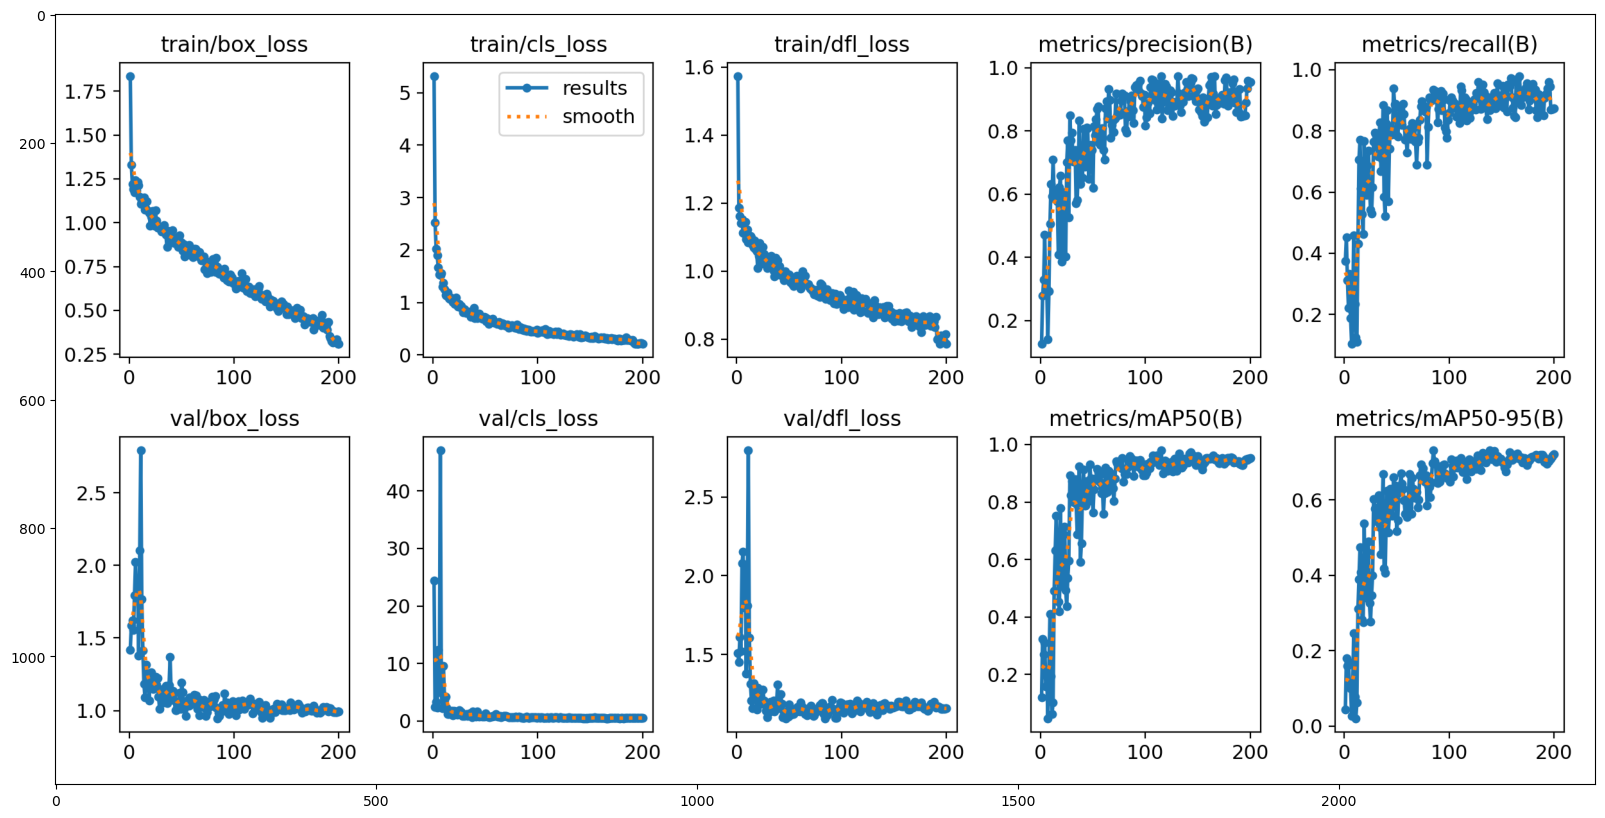

In [65]:
# results
MODEL_DIR = MODEL_SAVE_DIR+'/YOLO_brain-tumor'

plt.figure(figsize=(20, 10))
img = Image.open(MODEL_DIR+'/results.png')
plt.imshow(img)
plt.show()

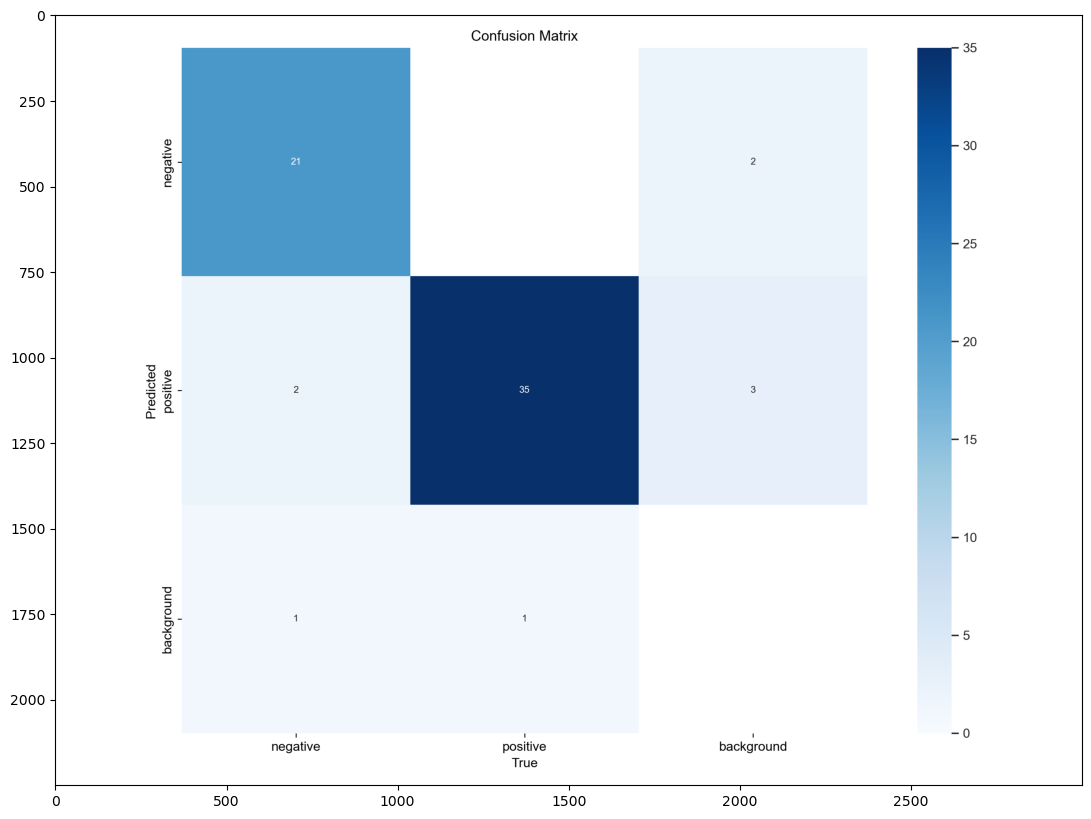

In [67]:
# confusion matrix
plt.figure(figsize=(20, 10))
img = Image.open(MODEL_DIR+'/confusion_matrix.png')
plt.imshow(img)
plt.show()

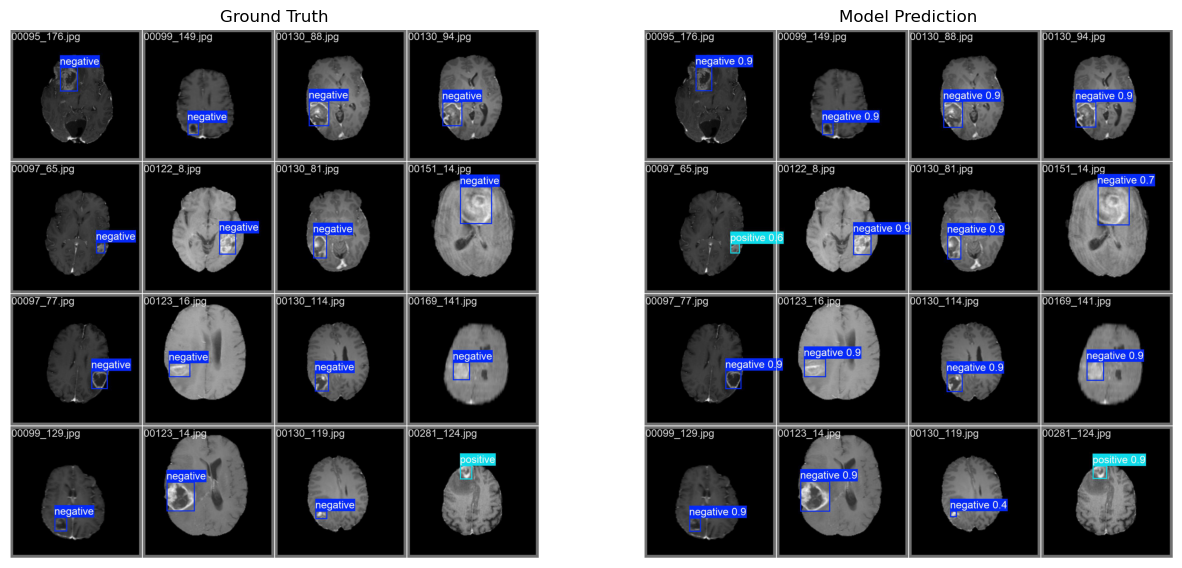

In [ ]:
# 검증 데이터 실제
img_actual = Image.open(MODEL_DIR+'/val_batch0_labels.jpg')
img_pred = Image.open(MODEL_DIR+'/val_batch0_pred.jpg')

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(img_actual)
axes[0].set_title('Ground Truth')
axes[0].axis('off')

axes[1].imshow(img_pred)
axes[1].set_title('Model Prediction')
axes[1].axis('off')

plt.show()

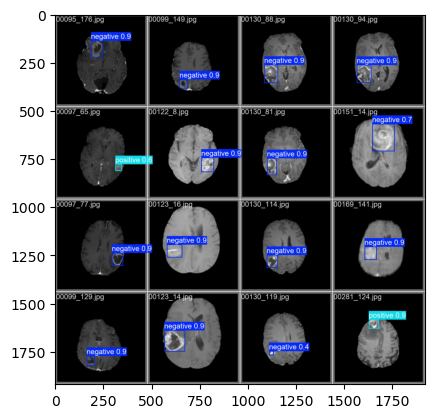

In [69]:
# 검증 데이터 예측
img = Image.open(MODEL_DIR+'/val_batch0_pred.jpg')
plt.imshow(img)
plt.show()

### 5) 성능 평가

In [ ]:
best_weight = os.path.join(MODEL_DIR, 'weights/best.pt')
test_images = os.path.join(TEST_DIR, 'images')
test_labels = os.path.join(TEST_DIR, 'labels')

In [74]:
# 평가 데이터셋으로 테스트
model = YOLO(best_weight)
results = model.predict(source=test_images, conf=0.25)


image 1/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00018_101.jpg: 640x640 1 negative, 7.3ms
image 2/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00018_109.jpg: 640x640 1 negative, 6.1ms
image 3/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00018_111.jpg: 640x640 1 negative, 6.3ms
image 4/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00018_117.jpg: 640x640 1 negative, 7.3ms
image 5/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00018_121.jpg: 640x640 1 negative, 8.9ms
image 6/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00018_126.jpg: 640x640 1 negative, 8.0ms
image 7/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00018_134.jpg: 640x640 (no detections), 6.5ms
image 8/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00019_66.jpg: 640x640 1 negative, 6.1ms
image 9/75 f:\\\\portfolio\AI\AI\dataset\brain_tumor\total\test\images\00019_75.jpg: 640x640 2 nega

In [78]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'negative', 1: 'positive'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
      

In [ ]:
# 이미지 + 라벨 (바운딩박스 포함)
def draw_img_label(img, label, thickness=2):

    x_size, y_size = img.size
    label_text, cx, cy, w, h = label
    
    cx = cx * x_size
    cy = cy * y_size
    w = w * x_size
    h = h * y_size

    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w/2, cy - h/2), (cx + w/2, cy + h/2)), outline='white', width=thickness)
    draw.text((cx - w/2, cy - h/2 - 15), str(label_text), fill='white')

    return img

In [117]:
def show_predicted_vs_real(index):

    # 모델 예측 결과 이미지
    pred_result = results[index]
    pred_image = pred_result.plot()

    # 실제 데이터 이미지
    image_name = os.path.basename(pred_result.path)
    real_path = os.path.join(test_images, image_name)
    real_image = Image.open(real_path)
    
    # 실제 데이터 라벨
    label_path = os.path.join(test_labels, os.path.splitext(image_name)[0] + '.txt')
    with open(label_path, 'r') as f:
        label = tuple(map(float, f.readline().split()))

    # 실제 데이터 이미지+라벨
    image_with_label = draw_img_label(real_image, label)

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(pred_image)
    axes[0].set_title('Predicted Image (YOLO)')
    axes[0].axis('off')

    axes[1].imshow(image_with_label, cmap='gray')
    axes[1].set_title('Original Image (With Label)')
    axes[1].axis('off')

    plt.show()

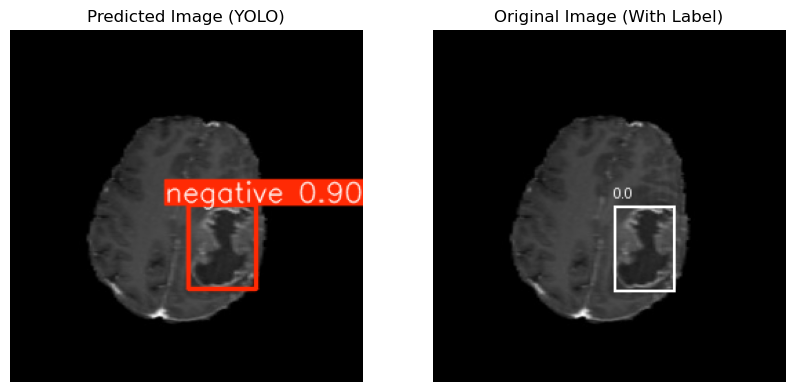

In [122]:
show_predicted_vs_real(index=4)

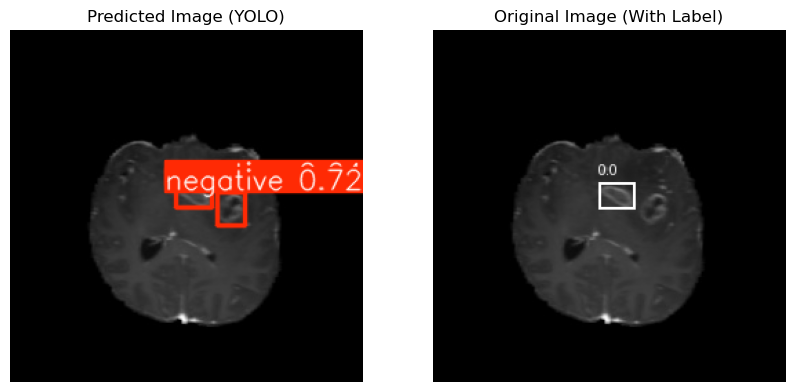

In [123]:
show_predicted_vs_real(index=8)

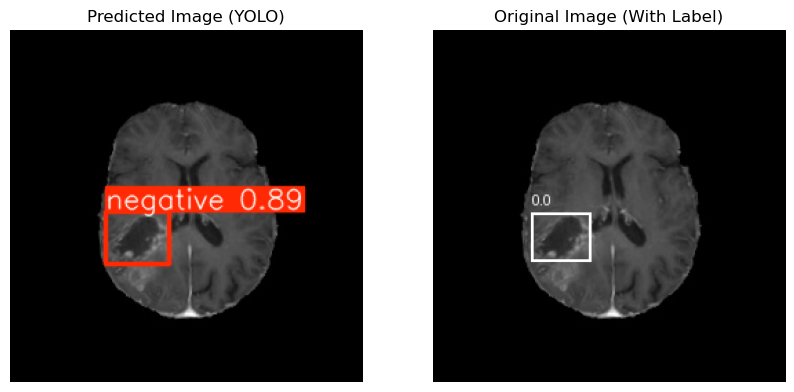

In [124]:
show_predicted_vs_real(index=12)